In [1]:
%load_ext autoreload
%autoreload 2

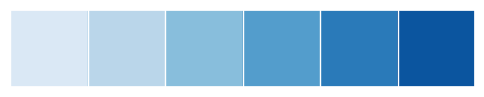

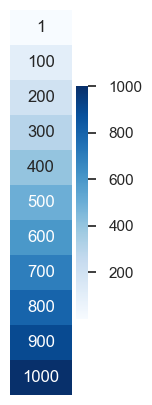

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.style.use(style="seaborn-v0_8-talk")
sns.set_theme(style="darkgrid")

PALETTE = "Blues"
sns.palplot(sns.color_palette(PALETTE))
matrix = np.linspace(1, 1000, 11).reshape(11, 1).astype(int)
fig = plt.figure(figsize=(1, 5))
sns_plot = sns.heatmap(
    matrix,
    annot=True,
    cmap=PALETTE,
    cbar=True,
    fmt=".0f",
    xticklabels=False,
    yticklabels=False,
)
plt.show()

In [3]:
from enum import Enum

class Stage(Enum):
    CC_IN = 0
    CV_IN = 1
    IDLE_IN = 2
    CC_OUT = 3
    IDLE_OUT = 4

def read_data(capacity_file, curve_file):
    df_capacity = pd.read_excel(capacity_file)
    df_curve = pd.read_excel(curve_file)

    def map_stage_to_enum(stage, last_stage):
        if stage == "恒流充电":
            return Stage.CC_IN
        elif stage == "恒压充电":
            return Stage.CV_IN
        elif stage == "搁置" and (
            last_stage == Stage.CV_IN or last_stage == Stage.IDLE_IN
        ):
            return Stage.IDLE_IN
        elif stage == "恒流放电":
            return Stage.CC_OUT
        elif stage == "搁置" and (
            last_stage == Stage.CC_OUT or last_stage == Stage.IDLE_OUT
        ):
            return Stage.IDLE_OUT
        else:
            raise ValueError("Unknown stage")

    CURVES = []

    # curve in CURVES:
    """
    curve = {
        data: [[voltage, current], [voltage, current], ...],
        stages: [(idx, idx), (idx, idx), ...], # idx is the index of stage, [idx, idx]
    }
    """

    stage, last_stage = None, None
    idx_start, idx_end = 0, -1
    cycle_num, last_cycle_num = 1, None
    data_list = []
    stages = []

    for i, row in df_curve.iterrows():
        idx_end += 1
        data = row[["电流(A)", "电压(V)"]].values.tolist()
        stage = map_stage_to_enum(row["工步类型"], last_stage)
        if last_stage is None:
            last_stage = stage
        if stage == last_stage:
            data_list.append(data)
            continue

        last_stage = stage
        stages.append((idx_start, idx_end))

        cycle_num = row["循环号"]
        if last_cycle_num is None:
            last_cycle_num = cycle_num

        if cycle_num == last_cycle_num:
            idx_start = idx_end
            data_list.append(data)
            continue

        curve = {
            "data": data_list,
            "stages": stages,
        }
        CURVES.append(curve)
        data_list = [data]
        stages = []
        idx_start, idx_end = 0, 0
        last_cycle_num = cycle_num

    LABELS = df_capacity["放电容量(Ah)"].values
    if len(LABELS) != len(CURVES):
        num_data = min(len(LABELS), len(CURVES))
        LABELS = LABELS[:num_data]
        CURVES = CURVES[:num_data]

    print(f"Total {len(CURVES)} curves, Total {len(LABELS)} labels")
    print(
        f"The first curve has {len(CURVES[0]['data'])} data points and {len(CURVES[0]['stages'])} stages"
    )

    return CURVES, LABELS


def get_closest_idx(arr, target):
    return np.argmin(np.abs(arr - target))


def get_vCC_iCV(curves, Vl, Il):
    voltage_CC = []
    current_CV = []
    for index, curve in enumerate(curves):
        if len(curve["stages"]) < 5:
            print(f"第{index+1}组数据不完整，跳过；它的stages是：")
            print(curve["stages"])
            continue
        CC = curve["stages"][Stage.CC_IN.value]
        CV = curve["stages"][Stage.CV_IN.value]
        data_CC = curve["data"][CC[0] : CC[1]]
        data_CV = curve["data"][CV[0] : CV[1]]
        v_CC = [d[1] for d in data_CC]
        i_CV = [d[0] for d in data_CV]
        idx_vl = get_closest_idx(np.array(v_CC), Vl)
        idx_il = get_closest_idx(np.array(i_CV), Il)
        voltage_CC.append(v_CC[idx_vl:])
        current_CV.append(i_CV[:idx_il])

    print("-" * 50)

    return voltage_CC, current_CV


def get_training_data(curves, labels, num_v, num_i):
    """
    将数据转换为训练数据，截取相同长度的电压和电流数据
    电压数据来源于恒压充电阶段的末尾，电流数据来源于恒流放电阶段的开头
    """
    valid_labels = []
    voltage_CC = []
    current_CV = []
    for index, curve in enumerate(curves):
        if len(curve["stages"]) < 5:
            print(f"第{index+1}组数据不完整，跳过；它的stages是：")
            print(curve["stages"])
            continue
        valid_labels.append(labels[index])
        CC = curve["stages"][Stage.CC_IN.value]
        CV = curve["stages"][Stage.CV_IN.value]
        data_CC = curve["data"][CC[0] : CC[1]]
        data_CV = curve["data"][CV[0] : CV[1]]
        v_CC = [d[1] for d in data_CC]
        i_CV = [d[0] for d in data_CV]
        voltage_CC.append(v_CC[-num_v:])
        current_CV.append(i_CV[:num_i])

    print("-" * 50)

    return voltage_CC, current_CV, valid_labels

In [4]:
CURVES, LABELS = read_data(capacity_file='./capacity.xlsx', curve_file='./curve.xlsx')


Total 868 curves, Total 868 labels
The first curve has 237 data points and 5 stages


绘制单个 cycle 的五阶段充放电曲线（电压和电流）

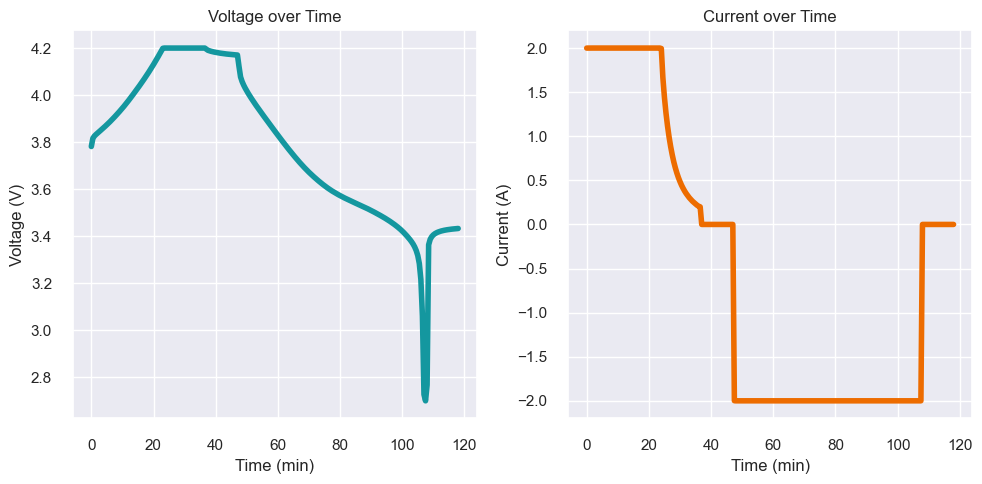

In [6]:
# 提取电压和电流数据
data = CURVES[0]["data"]
current_series = [d[0] for d in data]
voltage_series = [d[1] for d in data]
time_series = [e / 2 for e in range(len(data))]

# 绘制电压和电流曲线
plt.figure(figsize=(10, 5))

# 电压曲线
plt.subplot(1, 2, 1)
plt.plot(time_series, voltage_series, linestyle="-", color="#14979f", linewidth=4)
plt.title("Voltage over Time")
plt.xlabel("Time (min)")
plt.ylabel("Voltage (V)")

# 电流曲线
plt.subplot(1, 2, 2)
plt.plot(time_series, current_series, linestyle="-", color="#ed6c00", linewidth=4)
plt.title("Current over Time")
plt.xlabel("Time (min)")
plt.ylabel("Current (A)")

plt.tight_layout()
plt.show()

定义 CC 阶段的电压取样起止值和 CV 阶段的电流取样起止值

In [7]:
Vh = 4.2  # V
Vl = 4.0  # V

Ih = 2.0  # A
Il = 0.5  # A

CC-CV 充电阶段的电压和电流曲线

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot_CC_CV_curve(curves, cycle, Vl, Il):
    CC = curves[cycle]["stages"][Stage.CC_IN.value]
    CV = curves[cycle]["stages"][Stage.CV_IN.value]
    data_CC = curves[cycle]["data"][CC[0] : CC[1]]
    data_CV = curves[cycle]["data"][CV[0] : CV[1]]

    i_CC = [d[0] for d in data_CC]
    v_CC = [d[1] for d in data_CC]
    i_CV = [d[0] for d in data_CV]
    v_CV = [d[1] for d in data_CV]
    t_CC = [e / 2 for e in range(len(data_CC))]
    t_CV = [e / 2 for e in range(len(data_CC), len(data_CC) + len(data_CV))]

    idx_vh = -1
    idx_vl = get_closest_idx(np.array(v_CC), Vl)
    idx_ih = 0
    idx_il = get_closest_idx(np.array(i_CV), Il)

    # 绘制电压和电流曲线
    plt.figure(figsize=(10, 5))

    # 电压曲线
    plt.subplot(1, 2, 1)
    plt.plot(t_CC, v_CC, linestyle="-", linewidth=4, color="green")
    plt.plot(t_CV, v_CV, linestyle="-", linewidth=4, color="orange")
    plt.plot(t_CC[idx_vh], v_CC[idx_vh], marker="o", markersize=10, color="red")
    plt.plot(t_CC[idx_vl], v_CC[idx_vl], marker="o", markersize=10, color="red")
    plt.plot(
        t_CC + t_CV,
        [v_CC[idx_vl]] * len(t_CC + t_CV),
        label=f"y = {v_CC[idx_vl]}",
        linestyle="--",
        color="red",
    )

    plt.title("Voltage over Time")
    plt.xlabel("Time (min)")
    plt.ylabel("Voltage (V)")

    # 电流曲线
    plt.subplot(1, 2, 2)
    plt.plot(t_CC, i_CC, linestyle="-", linewidth=4, color="green")
    plt.plot(t_CV, i_CV, linestyle="-", linewidth=4, color="orange")
    plt.plot(t_CV[idx_ih], i_CV[idx_ih], marker="o", markersize=10, color="red")
    plt.plot(t_CV[idx_il], i_CV[idx_il], marker="o", markersize=10, color="red")
    plt.plot(
        t_CC + t_CV,
        [i_CV[idx_il]] * len(t_CC + t_CV),
        label=f"y = {i_CV[idx_il]}",
        linestyle="--",
        color="red",
    )
    plt.title("Current over Time")
    plt.xlabel("Time (min)")
    plt.ylabel("Current (A)")

    plt.tight_layout()
    plt.show()

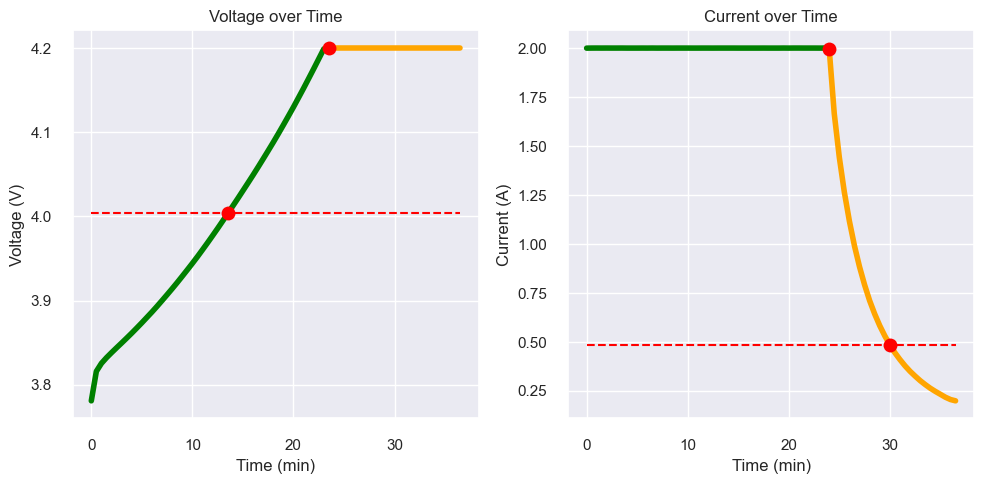

In [9]:
plot_CC_CV_curve(CURVES, 0, Vl, Il)

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def plot_main_curves(voltage_CC, current_CV, palette):
    plt.figure(figsize=(12, 6))

    # 绘制电压曲线
    plt.subplot(1, 2, 1)
    colors = sns.color_palette(palette, n_colors=len(voltage_CC))
    for idx, voltage in enumerate(voltage_CC):
        sns.lineplot(
            x=[t / 2 for t in range(len(voltage))],
            y=voltage,
            color=colors[idx],
            linewidth=0.5,
        )
    plt.title("Voltage over Time")
    plt.xlabel("Time (min)")
    plt.ylabel("Voltage (V)")

    # 绘制电流曲线
    plt.subplot(1, 2, 2)
    colors = sns.color_palette(
        palette,
        n_colors=len(current_CV),
    )
    for idx, current in enumerate(current_CV):
        sns.lineplot(
            x=[t / 2 for t in range(len(current))],
            y=current,
            color=colors[idx],
            linewidth=0.5,
            label=(f"Cycle {idx+1}" if idx == 0 or idx == len(current_CV) - 1 else None),
        )

    plt.title("Current over Time")
    plt.xlabel("Time (min)")
    plt.ylabel("Current (A)")

    # 设置图例
    handles, labels = plt.gca().get_legend_handles_labels()
    for handle in handles:
        handle.set_linewidth(2)  # 设置线条的粗细为2
    display_handles = [handles[0], handles[-1]]
    display_labels = [labels[0], labels[-1]]
    plt.legend(display_handles, display_labels)

    plt.tight_layout()
    plt.show()

绘制所有周期在选取区间内的电压和电流曲线：

电压曲线位于 CC 阶段

电流曲线位于 CV 阶段

第250组数据不完整，跳过；它的stages是：
[(0, 139)]
第251组数据不完整，跳过；它的stages是：
[(0, 24), (24, 45), (45, 163), (163, 184)]
第260组数据不完整，跳过；它的stages是：
[(0, 111)]
第261组数据不完整，跳过；它的stages是：
[(0, 24), (24, 45), (45, 163), (163, 184)]
--------------------------------------------------


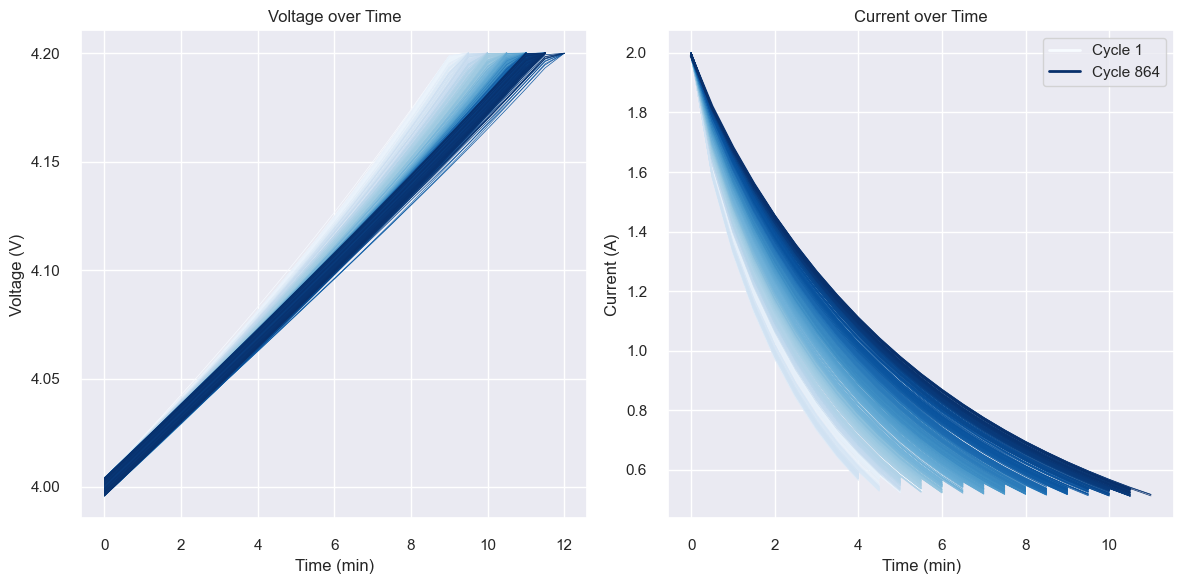

In [11]:
voltage_CC, current_CV = get_vCC_iCV(CURVES, Vl, Il)
    
plot_main_curves(voltage_CC, current_CV, PALETTE)

直接指定电压和电流的数据量

In [12]:
NUM_V = 20
NUM_I = 10

第250组数据不完整，跳过；它的stages是：
[(0, 139)]
第251组数据不完整，跳过；它的stages是：
[(0, 24), (24, 45), (45, 163), (163, 184)]
第260组数据不完整，跳过；它的stages是：
[(0, 111)]
第261组数据不完整，跳过；它的stages是：
[(0, 24), (24, 45), (45, 163), (163, 184)]
--------------------------------------------------
voltage_CC num: 864, data length: 20
current_CV num: 864, data length: 10


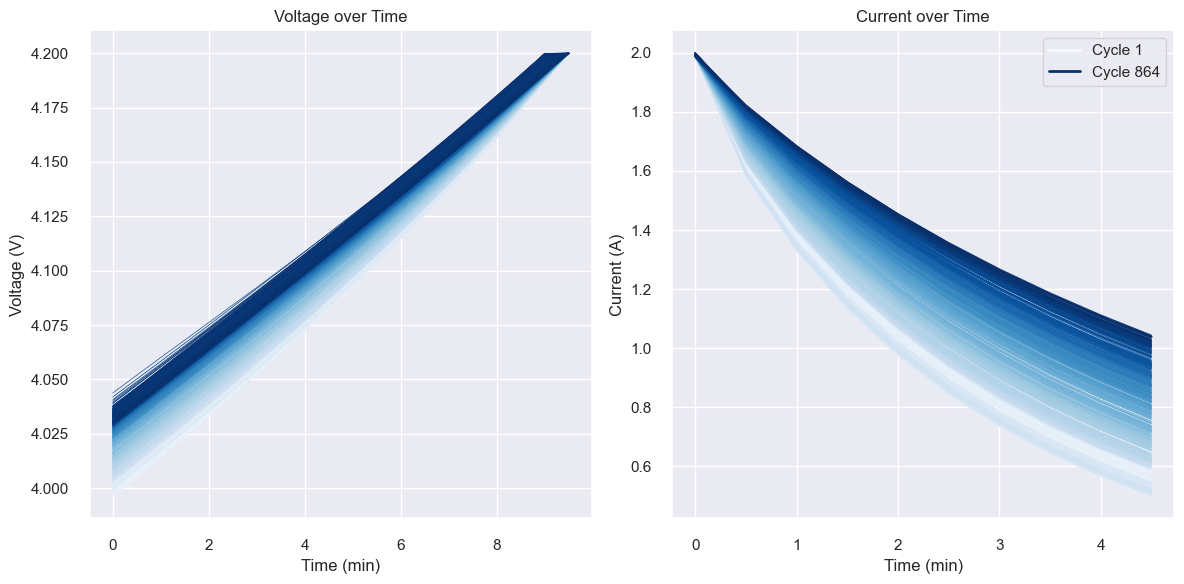

In [13]:
voltage_CC, current_CV, _ = get_training_data(CURVES, LABELS, NUM_V, NUM_I)

print(f"voltage_CC num: {len(voltage_CC)}, data length: {len(voltage_CC[0])}")
print(f"current_CV num: {len(current_CV)}, data length: {len(current_CV[0])}")

plot_main_curves(voltage_CC, current_CV, PALETTE)

容量曲线

In [5]:
THRESHOLD = 0.83

In [6]:
def get_80pct_cycle(capacity):
    cnt = 0
    threshold_capacity = capacity[0] * THRESHOLD
    print(f"Threshold capacity: {threshold_capacity}")
    for i in range(len(capacity)):
        if capacity[i] < threshold_capacity:
            if cnt == 0:
                target = i
            if cnt == 5:
                print(f"80% cycle found at {target}, capacity: {capacity[target]}")
                return target, capacity[target]
            cnt += 1
        else:
            cnt = 0
    raise ValueError("No 80% cycle found")

Threshold capacity: 1.647052
80% cycle found at 859, capacity: 1.6427


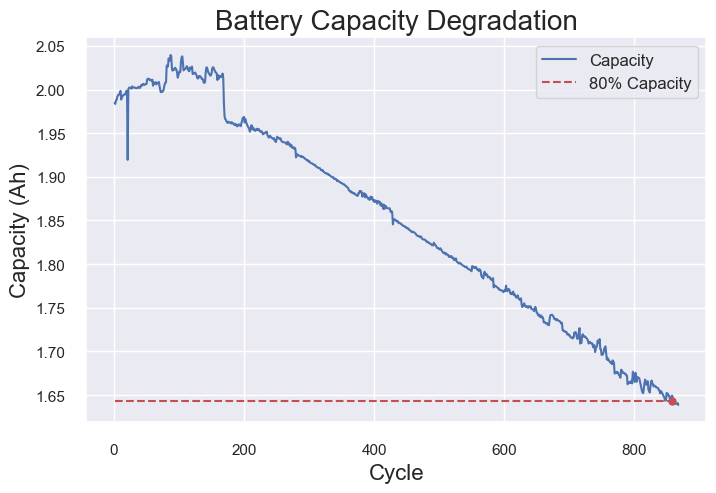

In [7]:
def plot_raw(true_capacity):
    capacity = []
    for idx, capa in enumerate(true_capacity):
        if capa < 1e-3:
            capa = (true_capacity[idx - 1] + true_capacity[idx + 1]) / 2
        capacity.append(capa)
    
    cycle = np.arange(1, len(capacity) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(cycle, capacity, "b-", label="Capacity", markersize=3)
    p_x, p_y = get_80pct_cycle(capacity)
    plt.plot(p_x, p_y, "ro")
    plt.plot(cycle, [p_y for _ in range(len(cycle))], "r--", label="80% Capacity")
    plt.title("Battery Capacity Degradation", fontsize=20)
    plt.xlabel("Cycle", fontsize=16)
    plt.ylabel("Capacity (Ah)", fontsize=16)
    plt.legend(fontsize=12)
    plt.show()
    
plot_raw(LABELS)